## Step 0: Set up

We set constants (paths + horizon), create output folders, and import PyTorch + sklearn utilities.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Horizon used in preprocessing (must match the filenames you saved)
H = 3

In [3]:
# Paths
DATA_PROCESSED_DIR = "data/processed"
OUT_PRED_DIR = "outputs/predictions"
OUT_FIG_DIR = "outputs/figures"

os.makedirs(OUT_PRED_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Step 1: Load the preprocessed splits and define features

We load `train/val/test` daily CSVs produced by `preprocessing.py`, then define the exact feature columns we’ll use.



In [4]:
# Load the daily splits from preprocessing
train_path = os.path.join(DATA_PROCESSED_DIR, f"train_daily_H{H}.csv")
val_path   = os.path.join(DATA_PROCESSED_DIR, f"val_daily_H{H}.csv")
test_path  = os.path.join(DATA_PROCESSED_DIR, f"test_daily_H{H}.csv")

train_df = pd.read_csv(train_path, parse_dates=["date"])
val_df   = pd.read_csv(val_path, parse_dates=["date"])
test_df  = pd.read_csv(test_path, parse_dates=["date"])

print("Rows (train/val/test):", len(train_df), len(val_df), len(test_df))

Rows (train/val/test): 1214 270 256


In [5]:
feature_cols = [
    "sent_mean", "sent_std", "n_tweets",
    "sent_mean_lag1", "sent_std_lag1", "n_tweets_lag1",
    "ret", "ret_lag1"
]

In [6]:
# Targets and ticker ids
y_train = train_df["y"].to_numpy(dtype=np.int64)
y_val   = val_df["y"].to_numpy(dtype=np.int64)
y_test  = test_df["y"].to_numpy(dtype=np.int64)

tid_train = train_df["ticker_id"].to_numpy(dtype=np.int64)
tid_val   = val_df["ticker_id"].to_numpy(dtype=np.int64)
tid_test  = test_df["ticker_id"].to_numpy(dtype=np.int64)

print("Feature count:", len(feature_cols))

Feature count: 8


## Step 2: Scale features and build PyTorch Dataset/DataLoaders

Scale numeric features using train-only stats, then wrap `(X, ticker_id, y)` into a Dataset and DataLoaders.
MLP trains better with scaled inputs, and DataLoaders make training clean and batch-based.


In [8]:
# Scale numeric features 
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

X_train = scaler.transform(train_df[feature_cols]).astype(np.float32)
X_val   = scaler.transform(val_df[feature_cols]).astype(np.float32)
X_test  = scaler.transform(test_df[feature_cols]).astype(np.float32)

# Number of tickers (for embedding table size)
num_tickers = int(max(tid_train.max(), tid_val.max(), tid_test.max()) + 1)
print("Num tickers:", num_tickers)


Num tickers: 6


In [9]:
# Dataset
class DailyMLPDataset(Dataset):
    """
    Each item:
      x   -> (C,) scaled numeric features
      tid -> scalar ticker_id (for embedding)
      y   -> scalar label (0/1)
    """
    def __init__(self, X, tid, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.tid = torch.tensor(tid, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.tid[idx], self.y[idx]

train_ds = DailyMLPDataset(X_train, tid_train, y_train)
val_ds   = DailyMLPDataset(X_val, tid_val, y_val)
test_ds  = DailyMLPDataset(X_test, tid_test, y_test)

In [10]:
# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Sanity check
xb, tidb, yb = next(iter(train_loader))
print("Batch x:", xb.shape)      # (batch, C)
print("Batch tid:", tidb.shape)  # (batch,)
print("Batch y:", yb.shape)      # (batch,)

Batch x: torch.Size([64, 8])
Batch tid: torch.Size([64])
Batch y: torch.Size([64])


## Step 3: Define the MLP with a ticker embedding

We build a small MLP that takes the daily numeric features, concatenates a learned ticker embedding, and outputs 2 logits (down/up).
One shared model can learn general patterns, while the ticker embedding lets it adapt to each asset.


In [12]:
class MLPWithTickerEmbedding(nn.Module):
    def __init__(self, num_features, num_tickers, emb_dim=8, hidden_size=64, dropout=0.1):
        super().__init__()

        # Learned vector per ticker_id
        self.emb = nn.Embedding(num_tickers, emb_dim)

        # Simple MLP head
        self.fc1 = nn.Linear(num_features + emb_dim, hidden_size)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 2)  # 2 classes: down/up

    def forward(self, x, ticker_id):
        # x: (batch, C)
        # ticker_id: (batch,)
        e = self.emb(ticker_id)              # (batch, emb_dim)
        z = torch.cat([x, e], dim=1)         # (batch, C + emb_dim)

        z = F.relu(self.fc1(z))
        z = self.drop(z)
        logits = self.fc2(z)
        return logits


In [13]:
# Instantiate model
num_features = X_train.shape[1]
model = MLPWithTickerEmbedding(
    num_features=num_features,
    num_tickers=num_tickers,
    emb_dim=8,
    hidden_size=64,
    dropout=0.1
).to(device)

print(model)

MLPWithTickerEmbedding(
  (emb): Embedding(6, 8)
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [14]:
# Forward sanity check
xb, tidb, yb = next(iter(train_loader))
xb, tidb = xb.to(device), tidb.to(device)
logits = model(xb, tidb)
print("Logits shape:", logits.shape)  # (batch, 2)

Logits shape: torch.Size([64, 2])


## Step 4: Train (with validation each epoch)

We train the MLP with CrossEntropy loss + Adam, tracking train/val accuracy per epoch and keeping the best model.
This lets us avoid overfitting by selecting the best validation checkpoint.


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_one_epoch(model, loader, train=True):
    # Train mode vs eval mode
    model.train() if train else model.eval()

    total_loss = 0.0
    total_correct = 0
    total_count = 0

    for xb, tidb, yb in loader:
        xb = xb.to(device)
        tidb = tidb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(xb, tidb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == yb).sum().item()
        total_count += xb.size(0)

    return total_loss / total_count, total_correct / total_count



In [16]:
EPOCHS = 15
best_val_acc = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, train=True)
    val_loss, val_acc     = run_one_epoch(model, val_loader, train=False)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f}")

    # keep best checkpoint by val accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}


Epoch 01 | train loss 0.6958 acc 0.536 | val loss 0.6899 acc 0.515
Epoch 02 | train loss 0.6919 acc 0.530 | val loss 0.6906 acc 0.507
Epoch 03 | train loss 0.6911 acc 0.540 | val loss 0.6937 acc 0.504
Epoch 04 | train loss 0.6882 acc 0.541 | val loss 0.6949 acc 0.500
Epoch 05 | train loss 0.6874 acc 0.532 | val loss 0.6964 acc 0.470
Epoch 06 | train loss 0.6864 acc 0.550 | val loss 0.6942 acc 0.526
Epoch 07 | train loss 0.6869 acc 0.535 | val loss 0.6984 acc 0.463
Epoch 08 | train loss 0.6817 acc 0.568 | val loss 0.6952 acc 0.507
Epoch 09 | train loss 0.6853 acc 0.553 | val loss 0.6972 acc 0.470
Epoch 10 | train loss 0.6828 acc 0.557 | val loss 0.6980 acc 0.493
Epoch 11 | train loss 0.6811 acc 0.572 | val loss 0.6975 acc 0.500
Epoch 12 | train loss 0.6780 acc 0.555 | val loss 0.6982 acc 0.485
Epoch 13 | train loss 0.6790 acc 0.566 | val loss 0.6968 acc 0.481
Epoch 14 | train loss 0.6775 acc 0.577 | val loss 0.6994 acc 0.504
Epoch 15 | train loss 0.6783 acc 0.569 | val loss 0.6984 acc 0

In [18]:
# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)

print("Best val acc:", round(best_val_acc, 3))

Best val acc: 0.541


The model goes through the data multiple times (epochs). In each epoch we print:

* **train loss / train acc**: how well the model fits the training set
* **val loss / val acc**: how well it generalises to unseen validation data

We then keep the **best model checkpoint**, meaning the weights from the epoch with the **highest validation accuracy**. At the end, we restore that best checkpoint and print the **best val acc** (here it is **0.541**). This way, we don’t just use the last epoch (which could be overfitting), we use the one that performed best on validation.


## Step 5: Test evaluation and save predictions and plots

We run the trained MLP on the test set, compute accuracy + AUC, plot confusion matrix + ROC curve, and save a predictions CSV.


In [19]:
model.eval()

# Collect predictions on test
all_y = []
all_pred = []
all_proba_up = []
all_tid = []
all_dates = []

with torch.no_grad():
    for xb, tidb, yb in test_loader:
        xb = xb.to(device)
        tidb = tidb.to(device)

        logits = model(xb, tidb)
        probs = torch.softmax(logits, dim=1)[:, 1]   # probability of class "up"
        pred = torch.argmax(logits, dim=1)

        all_y.append(yb.numpy())
        all_pred.append(pred.cpu().numpy())
        all_proba_up.append(probs.cpu().numpy())
        all_tid.append(tidb.cpu().numpy())

y_true = np.concatenate(all_y)
y_pred = np.concatenate(all_pred)
proba_up = np.concatenate(all_proba_up)
tid_test_out = np.concatenate(all_tid)


In [20]:
# Accuracy
test_acc = accuracy_score(y_true, y_pred)
print("Test accuracy:", round(float(test_acc), 3))

Test accuracy: 0.547


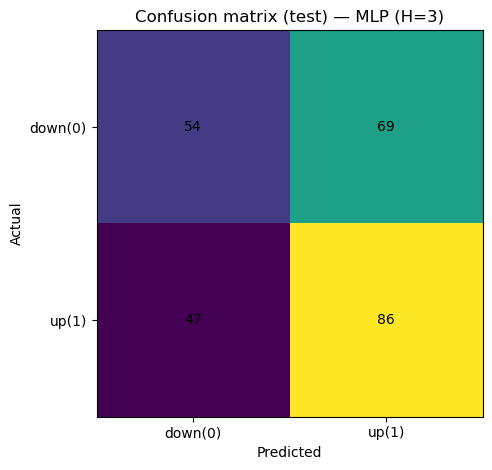

Saved: outputs/figures/mlp_confusion_H3.png


In [21]:
# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title(f"Confusion matrix (test) — MLP (H={H})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["down(0)", "up(1)"])
plt.yticks([0, 1], ["down(0)", "up(1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()

cm_path = os.path.join(OUT_FIG_DIR, f"mlp_confusion_H{H}.png")
plt.savefig(cm_path)
plt.show()
print("Saved:", cm_path)

On the test set, the MLP is again only slightly better than random. From the confusion matrix, it correctly predicts 54 downs and 86 ups, but it still makes a lot of mistakes in both directions (it predicts up when the market actually goes down 69 times, and predicts down when it actually goes up 47 times). The ROC curve confirms this: the AUC is 0.530, which is just a bit above 0.5. So the MLP is learning some weak signal, but it’s not clearly separating “up” vs “down” for the next 3-day horizon yet, and we’ll need to see if the sequence models (CNN/LSTM) improve on this baseline.

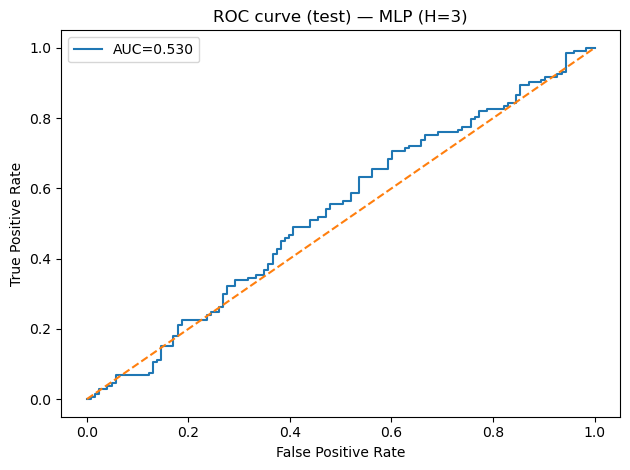

Saved: outputs/figures/mlp_roc_H3.png
Test AUC: 0.53


In [23]:
# ROC + AUC
auc = roc_auc_score(y_true, proba_up)
fpr, tpr, _ = roc_curve(y_true, proba_up)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC curve (test) — MLP (H={H})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()

roc_path = os.path.join(OUT_FIG_DIR, f"mlp_roc_H{H}.png")
plt.savefig(roc_path)
plt.show()
print("Saved:", roc_path)

print("Test AUC:", round(float(auc), 3))




In [24]:
# Save predictions CSV 
preds = test_df[["date", "ticker_id"]].copy()
preds["proba_up"] = proba_up
preds["pred_up"] = y_pred
preds["actual_up"] = y_true
preds["correct"] = (preds["pred_up"] == preds["actual_up"]).astype(int)

preds = preds.sort_values(["date", "ticker_id"]).reset_index(drop=True)

out_csv = os.path.join(OUT_PRED_DIR, f"mlp_predictions_H{H}.csv")
preds.to_csv(out_csv, index=False)
print("Saved:", out_csv)

preds.head()

Saved: outputs/predictions/mlp_predictions_H3.csv


,date,ticker_id,proba_up,pred_up,actual_up,correct
0,2023-11-05,1,0.592898,1,0,0
1,2023-11-05,2,0.417865,0,1,0
2,2023-11-06,0,0.510320,1,1,1
3,2023-11-06,1,0.605806,1,0,0
4,2023-11-06,2,0.452054,0,1,0
